# Task 2 Encoding and Classifier

## Problem 
<br>
Encoding the following files in a quantum circuit mock_train_set.csv and mock_test_set.csv in at least two different ways (these could be basis, angle, amplitude, kernel or random encoding
<br>
<br>
● Design a variational quantum circuit for each of the encodings, uses the column 4 as the target, this is a binary class 0 and 1.<br>
● You must use the data from column0 to column3 for your proposed classifier.<br>
● Consider the ansatz you are going to design as a layer and find out how many layers are
necessary to reach the best performance. <br>

### Analyze and discuss the results

Feel free to use existing frameworks (e.g. PennyLane, Qiskit) for creating and training the circuits.<br><br>
This PennyLane demo can be useful: Training a quantum circuit with Pytorch,<br>
This Quantum Tensorflow tutorial can be useful: Training a quantum circuit with Tensorflow.<br>
For the variational circuit, you can try any circuit you want. You can start from one with a layer of RX, RZ and CNOTs.<br>
<br>
## References
* https://pennylane.ai/qml/demos/tutorial_state_preparation.html
* https://www.tensorflow.org/quantum/tutorials/mnist

<br>

## Clasification 

In [63]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from ipywidgets import widgets
from IPython.display import display, HTML

In [64]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

import sys
from math import sqrt, pi

import pandas as pd
import scipy
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
# supress a warning that is not useful here
pd.options.mode.chained_assignment = None


In [65]:
path_train = '/_jupyter/QC/QOSF-challenge-md-2022/task-02/mock_train_set.csv'
path_test = '/_jupyter/QC/QOSF-challenge-md-2022/task-02/mock_test_set.csv'

num_qubits = 2
num_layers = 4

dev = qml.device("default.qubit", wires=num_qubits)

# #################################################################################
# used to compute features
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.sqrt(x[2] ** 2 + x[3] ** 2)/np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2))

    return np.array(
            [
                beta2, 
                -beta1/2, 
                beta1/2, 
                -beta0/2, 
                beta0/2
            ])


# sklearn StandardScaler
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html


df = pd.read_csv(path_train)
df_c = df.copy(deep=True)
df['1'] = np.log10(df_c['1'])
df['2'] = np.log10(df_c['2'])

f = lambda x: -1.0 if x==0 else 1.0
df['4'] = df_c['4'].map(f)

# # test
# ff = lambda x: 1
# df['0'] = df_c['0'].map(ff)

# npdf = df2.to_numpy()
npdf = df.to_numpy()
data = np.array(npdf)

print("\n\nTrain data standardised:\n", data)

X = data[:, 0:4]
Y = data[:, -1]

# scale the data using sklearn StandardScaler
std_slc = StandardScaler(with_mean=False)
std_slc.fit(X)
X_std = std_slc.transform(X)

# ###################################################################
# padding
# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X_std), 1))
X_pad = np.c_[np.c_[X_std, padding], np.zeros((len(X_std), 1))]

print("\n\nFirst X sample (padded):\n", X_pad[0:5])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T

print("\n\nFirst X sample (normalized):\n", X_norm[0:5])

# angles for state preparation are new features
# we use get_angles to compute features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("\n\nFirst features sample:\n", features[0:5])




Train data standardised:
 [[ 2.78926e+03  3.00000e+00  1.00000e+00  2.00000e+01 -1.00000e+00]
 [ 4.04001e+03  6.00000e+00  0.00000e+00  1.00000e+00  1.00000e+00]
 [ 2.93120e+03  4.00000e+00  4.00000e+00  4.00000e+01  1.00000e+00]
 ...
 [ 4.18281e+03  0.00000e+00  0.00000e+00  6.50000e+01 -1.00000e+00]
 [ 3.11375e+03  4.00000e+00  2.00000e+00  1.00000e+00  1.00000e+00]
 [ 4.56757e+03  4.00000e+00  5.00000e+00  9.00000e+01  1.00000e+00]]


StandardScaler(with_mean=False)



First X sample (padded):
 [[1.97297308 1.25991244 0.50097227 0.72879296 0.3        0.        ]
 [2.85768662 2.51982488 0.         0.03643965 0.3        0.        ]
 [2.07337383 1.67988325 2.00388909 1.45758593 0.3        0.        ]
 [2.75620362 1.67988325 2.50486137 1.09318945 0.3        0.        ]
 [0.69465663 0.83994163 1.50291682 2.73297362 0.3        0.        ]]


First X sample (normalized):
 [[0.78282016 0.49989778 0.19877169 0.28916452 0.11903155 0.        ]
 [0.74770596 0.65930536 0.         0.00953434 0.07849419 0.        ]
 [0.56744068 0.45975023 0.54842411 0.39891193 0.08210396 0.        ]
 [0.65003971 0.39619381 0.59076164 0.2578244  0.07075381 0.        ]
 [0.2093902  0.25318342 0.45302389 0.82379965 0.09042894 0.        ]]


First features sample:
 [[ 0.72241941 -0.9685769   0.9685769  -0.56830923  0.56830923]
 [ 0.01912798 -1.57069144  1.57069144 -0.722652    0.722652  ]
 [ 1.49677071 -0.62886549  0.62886549 -0.68094     0.68094   ]
 [ 1.40516626 -0.41150958  0.4115

### test angle encoding

Circuit coding for angle encoding follows pennylane technique, whch is also following the scheme in in Schuld and Petruccione (2018).<br>
""We had to also decompose controlled Y-axis rotations into more basic circuits following Nielsen and Chuang (2010).""<br>

* https://link.springer.com/book/10.1007/978-3-319-96424-9
* 

In [66]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

# ###################################################################
# used to encode the state
# in this case we're not using the out of box qml.AngleEmbedding
def statepreparation(a):
    
    qml.RY(a[0], wires=0)
    qml.CNOT(wires=[0, 1])

    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.RY(a[2], wires=1)
    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])

    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)    


@qml.qnode(dev)
def circuit(weights, angles):
    
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias

# ###############################################################################
# standard square loss
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

# ###############################################################################
# goal: maximize accuracy
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)



<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Original data')

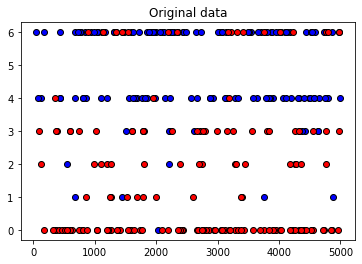

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Padded and normalised data (dims 0 and 1)')

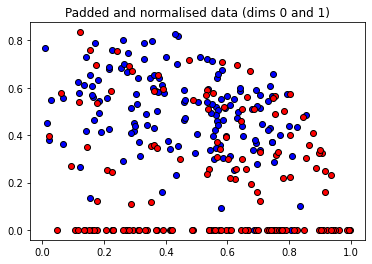

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Feature vectors (dims 0 and 2)')

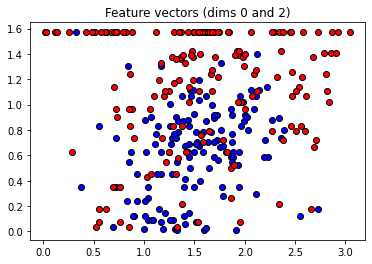

In [67]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 2
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

In [68]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

# ##################################################################
# Load the test dataset and apply same transformations 
# as we did with the train dataset.
df_test = pd.read_csv(path_test)
df_test_c = df_test.copy(deep=True)
df_test['1'] = np.log10(df_test_c['1'])
df_test['2'] = np.log10(df_test_c['2'])

f = lambda x: -1.0 if x==0 else 1.0
df_test['4'] = df_test_c['4'].map(f)
data_test = df_test.to_numpy()

# # test
# ff = lambda x: 1
# df_test['0'] = df_test_c['0'].map(ff)

X_test_ini = data_test[:, 0:4]
Y_test = data_test[:, -1]

# scale data using sklearn StandardScaler
std_slc = StandardScaler(with_mean=False)
std_slc.fit(X_test_ini)
X_test_std = std_slc.transform(X_test_ini)

# ###################################################################
# padding
# pad the vectors to size 2^2 with constant values
padding_test = 0.3 * np.ones((len(X_test_std), 1))
X_test_pad = np.c_[np.c_[X_test_std, padding_test], np.zeros((len(X_test_std), 1))]

# normalize each input
normalization_t = np.sqrt(np.sum(X_test_pad ** 2, -1))
X_test_norm = (X_test_pad.T / normalization_t).T

# convert to a pennylane numpy array
X_test_norm = np.array(X_test_norm, requires_grad=False)

# we use get_angles to compute features
features_test = np.array([get_angles(x) for x in X_test_norm], requires_grad=False)


StandardScaler(with_mean=False)

In [69]:
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)
# opt = NesterovMomentumOptimizer(0.1)

# batch_size = 5
# batch_size = 15
# batch_size = 20
batch_size = 10

# train the variational classifier
weights = weights_init
bias = bias_init

steps = 65
# steps = 5

for it in range(steps):
# for it in range(2):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    # print(
    #     "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
    #     "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    # )

    acc_test = test_accuracy(weights, bias)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} | Acc test: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val, acc_test)
    )

    if acc_train >= 0.93 and acc_val >= 0.93:
        # early stop
        break

print('\n\nbias: ', bias)    
print('\n\nweights:\n', weights)


Iter:     1 | Cost: 1.1970236 | Acc train: 0.5288889 | Acc validation: 0.5066667 | Acc test: 0.4333333 
Iter:     2 | Cost: 1.1949626 | Acc train: 0.5288889 | Acc validation: 0.5066667 | Acc test: 0.4333333 
Iter:     3 | Cost: 1.1951781 | Acc train: 0.5288889 | Acc validation: 0.4933333 | Acc test: 0.4250000 
Iter:     4 | Cost: 1.1949685 | Acc train: 0.5200000 | Acc validation: 0.5333333 | Acc test: 0.4083333 
Iter:     5 | Cost: 1.2056650 | Acc train: 0.5111111 | Acc validation: 0.4933333 | Acc test: 0.3916667 
Iter:     6 | Cost: 1.2253643 | Acc train: 0.4888889 | Acc validation: 0.5066667 | Acc test: 0.3666667 
Iter:     7 | Cost: 1.2349042 | Acc train: 0.4933333 | Acc validation: 0.5333333 | Acc test: 0.3250000 
Iter:     8 | Cost: 1.2546894 | Acc train: 0.4977778 | Acc validation: 0.4933333 | Acc test: 0.3333333 
Iter:     9 | Cost: 1.2799439 | Acc train: 0.4888889 | Acc validation: 0.4933333 | Acc test: 0.3500000 
Iter:    10 | Cost: 1.3077183 | Acc train: 0.4933333 | Acc valid

In [70]:
# #########################################################################
# 
def test_accuracy(weights, bias):

    # apply the variational clasifier circuit on test dataset
    # using the learned weights
    predictions_test = [np.sign(variational_classifier(weights, bias, f)) for f in features_test]

    return accuracy(Y_test, predictions_test)

acc_test = test_accuracy(weights, bias)
print('Accuracy on test data: {:0.4f}'.format(acc_test))

Accuracy on test data: 0.9583


In [71]:
np.linspace(0.0, 1.5, 20)

tensor([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
        0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
        0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
        1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ], requires_grad=True)

In [72]:
# We can plot the continuous output of the variational classifier for the first two dimensions of the Iris data set.
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
# xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
xx, yy = np.meshgrid(np.linspace(0.0, 5000, 20), np.linspace(0.0, 10, 20))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

/tmp/ipykernel_52967/1061159923.py:19: UserWarning: No contour levels were found within the data range.
  plt.contour(


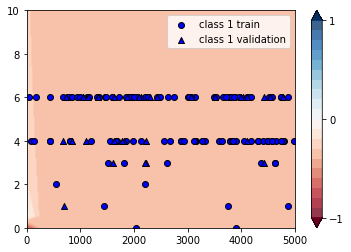

In [73]:

X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
    # xx, yy, Z, levels=np.arange(-10, 10.1, 1.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
# plt.scatter(
#     X_train[:, 0][Y_train == -1],
#     X_train[:, 1][Y_train == -1],
#     c="r",
#     marker="o",
#     edgecolors="k",
#     label="class -1 train",
# )
# plt.scatter(
#     X_val[:, 0][Y_val == -1],
#     X_val[:, 1][Y_val == -1],
#     c="r",
#     marker="^",
#     edgecolors="k",
#     label="class -1 validation",
# )

plt.legend()
plt.show()